
# Gen-Toolbox data analyis notebook

This notebook is part of the gen-toolbox project, a comprehensive tool designed for collating large numbers of VCF files from unique samples, annotating variants, and creating variant frequency tables. The project is tailored to run on substantial servers and has been spearheaded by the Tartu University Hospital Centre of Medical Genetics and the Tartu University Institute of Clinical Medicine, with the backing of the Estonian Research Council grant PSG774.

## Notebook Objective:

This particular notebook delves into the statistical analysis of Single Nucleotide Variants (SNVs) in genomic data. The aim is to:

- Load and process genomic data.
- Compute statistical metrics and ratios.
- Visualize results for a better understanding of the data.

## Prerequisites:

1. **Data Preparation**: Ensure you have the necessary VCF files and gene configurations. The notebook expects CSV or TSV formatted files.

2. **Environment Setup**: If using Docker, ensure Docker is installed and running. Alternatively, ensure you have a Python environment set up with all necessary libraries.

3. **Configuration**: Adjust path variables in the notebook to match the location of your data files.

### 0. Library Imports

In [48]:
import json
import os.path
import re


import scipy.stats as sp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Input variables

#### 1.1 Path variables - change these for specifing correct paths

In [49]:
gene_config = "/mnt/c/Users/ville/Documents/PycharmProjects/gen-toolbox/src/config/gene_config.json"
args_case =  "/mnt/c/Users/ville/OneDrive - Tartu Ülikool/Doktorantuur/Oligogeensus/Frequency_databases/frequency_table_896_VAM_positive.csv-20240121-1023" # add here TSV or CSV file with case data
args_control = "/mnt/c/Users/ville/OneDrive - Tartu Ülikool/Doktorantuur/Oligogeensus/Frequency_databases/frequency_table_3566_VAM_negative.csv-20240121-1151"# add here TSV or CSV file with control data

#### 1.2 Configuration variables

In [50]:
is_csv = True # if False, then tsv, if True, then csv
iterations = 200000 # number of iterations for permutation test
combination_length=5 # number of genes in a set
case_genes_length = combination_length  # e.g. sets of 5 genes


## 2. Utility functions

In [51]:
def load_gene_config(json_file):
    """Load gene configuration from a JSON file."""
    with open(json_file, "r") as file:
        config = json.load(file)
    return config

In [52]:
def extract_number_from_filename(filename: str) -> int:
    """Extract the number from the given filename."""
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else None

In [53]:
case_count = extract_number_from_filename(args_case) # extract number from filename
control_count = extract_number_from_filename(args_control) # extract number from filename


## 3. Data Loading

### 3.1 Loading Gene config

In [54]:
config = load_gene_config(gene_config)

In [55]:
# keys in gene_config would show information present in it
config.keys()

dict_keys(['intersect_genes_tso', 'intersect_genes_tshc', 'neg_control_genes', 'rv_genes'])

In [56]:
# Lets Show some of itersect genes
config['intersect_genes_tso'][:5]

['A2M', 'A4GALT', 'A4GNT', 'AAAS', 'AADAC']

In [57]:
# How many intersect genes are there
len(config['intersect_genes_tso'])

4811

In [58]:
# printing number of genes in each conf
for i in config:
    print(i,':', len(config[i]))

intersect_genes_tso : 4811
intersect_genes_tshc : 79
neg_control_genes : 8
rv_genes : 8


### 3.2 Getting rv_genes and neg_control_genes for use in our test

In [59]:
rv_genes = config["rv_genes"]
neg_control_genes = config["neg_control_genes"]

### 3.3 Loading case and control SNV data

For csv data file intersect_genes_tso is loaded while for tsv intersect_genes_tshc is loaded. Read the docs for clarification

In [60]:
if is_csv:
    intersect_genes = config["intersect_genes_tso"]
    df_case = pd.read_csv(args_case, sep=",", header=0)
    df_control = pd.read_csv(args_control, sep=",", header=0)
else:
    intersect_genes = config["intersect_genes_tshc"]
    df_case = pd.read_table(args_case, sep="\t", header=0)
    df_control = pd.read_table(args_control, sep="\t", header=0)

As we have loaded single file for case and control, both dataframes will be same

In [61]:
df_case.head(2)

,Unnamed: 0,HIGH.gnomad_1,HIGH.gnomad_1_5,HIGH.gnomad_5_100,MODERATE.gnomad_1,MODERATE.gnomad_1_5,MODERATE.gnomad_5_100,LOW.gnomad_1,LOW.gnomad_1_5,LOW.gnomad_5_100,MODIFIER.gnomad_1,MODIFIER.gnomad_1_5,MODIFIER.gnomad_5_100
0,A2M,0,0,252,19,27,2463,9,6,434,0,0,613
1,A4GNT,8,0,0,5,33,1104,15,0,2204,0,0,0


In [62]:
df_control.head(2)

,Unnamed: 0,HIGH.gnomad_1,HIGH.gnomad_1_5,HIGH.gnomad_5_100,MODERATE.gnomad_1,MODERATE.gnomad_1_5,MODERATE.gnomad_5_100,LOW.gnomad_1,LOW.gnomad_1_5,LOW.gnomad_5_100,MODIFIER.gnomad_1,MODIFIER.gnomad_1_5,MODIFIER.gnomad_5_100
0,A2M,0,0,952,77,91,9825,43,38,1686,1,0,2426
1,A4GNT,19,0,0,21,128,4364,49,3,8672,0,0,0


In [63]:
# Dataframe length
# Each row contains a gene
f'number of genes in case: {len(df_case)}', f'number of genes in control: {len(df_control)}'

('number of genes in case: 6774', 'number of genes in control: 6848')

### 3.4 Assigning the 1st column the name of gene

In [64]:
df_case.rename(columns={df_case.columns[0]: "gene"}, inplace = True)
df_control.rename(columns={df_control.columns[0]: "gene"}, inplace = True)

In [65]:
df_case.columns

Index(['gene', 'HIGH.gnomad_1', 'HIGH.gnomad_1_5', 'HIGH.gnomad_5_100',
       'MODERATE.gnomad_1', 'MODERATE.gnomad_1_5', 'MODERATE.gnomad_5_100',
       'LOW.gnomad_1', 'LOW.gnomad_1_5', 'LOW.gnomad_5_100',
       'MODIFIER.gnomad_1', 'MODIFIER.gnomad_1_5', 'MODIFIER.gnomad_5_100'],
      dtype='object')

### 3.5 Getting list of all genes

In [66]:
all_genes = df_case['gene']

## 4. Cleaning data

### 4.1 Selecting intersect gene from config

In [67]:
# Selecting only itersecting genes from config
if intersect_genes is not None:
    # Filter out empty genes and keep only the intersecting genes in both dataframes
    df_case = df_case.dropna(subset=["gene"])
    df_case = df_case[df_case.gene.isin(intersect_genes)]
    df_control = df_control.dropna(subset=["gene"])
    df_control = df_control[df_control.gene.isin(intersect_genes)]
    df_case.reset_index(drop=True, inplace=True)
    df_control.reset_index(drop=True, inplace=True)

In [68]:
# Dataframe length after selecting only intersecting genes available in config
f'number of genes in case: {len(df_case)}', f'number of genes in control: {len(df_control)}'

('number of genes in case: 4732', 'number of genes in control: 4750')

In [69]:
#Check if dataframes are of equal length
if len(df_case.index) != len(df_control.index):
    print("WARNING: Case dataframe length does not match control dataframe length! The intersect of both dataframes will be analysed.")

### 4.2 Taking intersect of both data frames and sorting on gene column

This step is performed to ensure that same genes for case and control are present and we can apply indexwise operation in our statistical test. Randomly selected indices will produce same genes from both data frames.

Sorting is done because if we select gene names randomly and then filter both dataframes for selected gene names then it will be a slow process


In [70]:
# Take only the intersect of two dataframes based on gene column
intersection_values = set(df_case['gene']).intersection(df_control['gene'])
df_case = df_case[df_case["gene"].isin(intersection_values)]
df_case = df_case.sort_values(by="gene")
df_control = df_control[df_control["gene"].isin(intersection_values)]
df_control = df_control.sort_values(by="gene")
df_case.reset_index(drop=True, inplace=True)
df_control.reset_index(drop=True, inplace=True)

In [71]:
# The rows must match in order to do index based math
assert df_case["gene"].equals(df_control["gene"]), "Case and control dataframe indices do not match!"

## 5. Statistical test

### 5.1 Initializing empty dataframes to store results

In [72]:
fraction_results_1 = pd.DataFrame()
fraction_results_2 = pd.DataFrame(columns=df_case.columns[1:].tolist())

### 5.2 Calculating desired variables

If we have passed only 1 file it will make expected_ratio to be 1

In [73]:
expected_ratio = case_count / control_count
df_case.reset_index(drop=True, inplace=True)
df_control.reset_index(drop=True, inplace=True)
columns_to_add = df_case.columns[1:]

# Calculate the mean of the case and control dataframes
df_case_mean = df_case.mean()
df_control_mean = df_control.mean()

num_columns = df_case.shape[1]

print("Case means \n{0}\nControl means \n{1}".format(df_case_mean, df_control_mean))
print("Expected ratio cases / controls: {0}, log2 {1}".format(expected_ratio, np.log2(expected_ratio)))
print("Expected ratio cases / controls by group (log2): \n {0}".format(np.log2(df_case_mean / df_control_mean)))

Case means 
HIGH.gnomad_1               1.043340
HIGH.gnomad_1_5             0.624313
HIGH.gnomad_5_100          15.109937
MODERATE.gnomad_1          17.904228
MODERATE.gnomad_1_5        20.930233
MODERATE.gnomad_5_100     703.022622
LOW.gnomad_1               13.346723
LOW.gnomad_1_5             18.298732
LOW.gnomad_5_100         1118.876110
MODIFIER.gnomad_1           2.604017
MODIFIER.gnomad_1_5         3.574419
MODIFIER.gnomad_5_100     193.913319
dtype: float64
Control means 
HIGH.gnomad_1               4.086258
HIGH.gnomad_1_5             2.528330
HIGH.gnomad_5_100          59.863636
MODERATE.gnomad_1          71.910359
MODERATE.gnomad_1_5        83.420085
MODERATE.gnomad_5_100    2794.981184
LOW.gnomad_1               53.731712
LOW.gnomad_1_5             72.872727
LOW.gnomad_5_100         4453.135941
MODIFIER.gnomad_1          10.509302
MODIFIER.gnomad_1_5        14.281607
MODIFIER.gnomad_5_100     771.158562
dtype: float64
Expected ratio cases / controls: 0.2512619181155356, lo

<ipython-input-73-a08a5dcc05a8>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_case_mean = df_case.mean()
<ipython-input-73-a08a5dcc05a8>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_control_mean = df_control.mean()


In [74]:
# Divisible columns, look at the ratios grossly
divison_result_gross = df_case[columns_to_add] / df_control[columns_to_add]
r = divison_result_gross[divison_result_gross[:-1] > expected_ratio].dropna(how="all")
r["gene"] = df_case["gene"]  ## Do nothing

### 5.2 Random selection of indices for statistical test

In [75]:
indices = np.array([np.random.choice(df_case.index, size=case_genes_length, replace=False) for _ in range(iterations)])

### 5.3 Taking sum for columns against selected indices for each iteration

In [76]:
# Calculate the sum of total variants for the case and control groups using the sampled indices
total_variants_case = np.array([df_case.iloc[idx, 1:].sum().to_numpy() for idx in indices])
total_variants_control = np.array([df_control.iloc[idx, 1:].sum().to_numpy() for idx in indices])

In [77]:
# Show what a single burden event looks like
total_variants_case
total_variants_control

array([[   5,    0,    0, ...,   58,    0, 3037],
       [   9,    0,    0, ...,   12,    4, 6669],
       [   4,   49,    0, ...,   11,   49,    0],
       ...,
       [  20,    0, 6196, ...,   29,   20,    1],
       [  21,   87,    0, ...,    7,    6, 5608],
       [  17,    0,  171, ...,   83,  233, 4017]])

### 5.4 Ratios vector for each column based on given condition to include sum

In [78]:
ratios_vector = np.where(np.logical_and(total_variants_case > 1, total_variants_control > 1),\
                total_variants_case / total_variants_control,\
                np.NaN)

<ipython-input-78-be4d68864605>:2: RuntimeWarning: divide by zero encountered in divide
  total_variants_case / total_variants_control,\
<ipython-input-78-be4d68864605>:2: RuntimeWarning: invalid value encountered in divide
  total_variants_case / total_variants_control,\


In [79]:
# numer of iterations and column number can be seen in shape
ratios_vector.shape

(200000, 12)

In [80]:
# Where sum is less than 1 NaN will be placed for the ratio in that
ratios_vector[0]

array([       nan,        nan,        nan, 0.25123153, 0.1025641 ,
       0.25324823, 0.33333333, 0.22641509, 0.25418777, 0.22413793,
              nan, 0.25814949])

### 5.5 Satisfying below statistical condition to get burden events
Low variant count events are not statistically significants.
I.e. gene sets containing only a few variants or variants in only one gene are excluded.
High variant burdens are expected between impactful genes in the different groups.



1. $$ \log_2\left(\frac{\text{ratios\_vector}}{\text{expected\_ratio}}\right) > 0.5 $$


2. $$ \text{total\_variants\_case} > \text{case\_genes\_length} $$


3. $$ \text{total\_variants\_control} > \text{case\_genes\_length} $$

4. $$ \text{ Nonzero values total\_variants\_control} > 1 $$

5. $$ \text{ Nonzero values total\_variants\_case} > 1 $$


In [81]:
fraction_results_tmp = pd.DataFrame(ratios_vector, columns=df_case.columns[1:].tolist())

complex_condition = (
    #(np.log2(ratios_vector/expected_ratio) > 0.5) &
    (total_variants_case > case_genes_length) &
    (total_variants_control > case_genes_length) &
    (np.count_nonzero(~np.isnan(total_variants_control)) > 1) &
    (np.count_nonzero(~np.isnan(total_variants_case)) > 1)
                    ).T.flatten()

gene = np.array([df_case.gene[idx].to_numpy() for idx in indices])
case = np.array([df_case.iloc[idx, 1:].to_numpy().T for idx in indices]).transpose((1, 0, 2))
control = np.array([df_control.iloc[idx, 1:].to_numpy().T for idx in indices]).transpose((1, 0, 2))
case = case.reshape((-1, case.shape[-1]))
control = control.reshape((-1, control.shape[-1]))
case_control = case/control

fraction_results_1 = pd.DataFrame()
fraction_results_1['frequency_bin'] = np.repeat(fraction_results_tmp.columns, len(fraction_results_tmp))
fraction_results_1['burden_ratio'] = fraction_results_tmp.to_numpy().T.flatten()
fraction_results_1['gene'] = list(np.tile(gene, (len(df_case.columns[1:].tolist()),1)))
fraction_results_1['case'] = list(case)
fraction_results_1['control'] = list(control)
fraction_results_1['case_control'] = list(case_control)
fraction_results_1 = fraction_results_1[complex_condition].reset_index(drop=True)
fraction_results_1['burden_event'] = list(range(len(fraction_results_1)))

<ipython-input-81-bb9c9d93da5e>:16: RuntimeWarning: divide by zero encountered in divide
  case_control = case/control
<ipython-input-81-bb9c9d93da5e>:16: RuntimeWarning: invalid value encountered in divide
  case_control = case/control


In [82]:
# while working with case and control data this condition will be me for some, not all samples
fraction_results_1

,frequency_bin,burden_ratio,gene,case,control,case_control,burden_event
0,HIGH.gnomad_1,0.127660,"[CISD2, SOD1, SEMA3A, TBX15, MYH6]","[0, 0, 0, 0, 6]","[0, 0, 0, 0, 47]","[nan, nan, nan, nan, 0.1276595744680851]",0
1,HIGH.gnomad_1,0.166667,"[NEIL1, TNFRSF4, IER3IP1, ISYNA1, KCNK6]","[5, 1, 0, 0, 0]","[31, 0, 0, 1, 4]","[0.16129032258064516, inf, nan, 0.0, 0.0]",1
2,HIGH.gnomad_1,0.250000,"[COLEC11, EXO1, CYBA, CC2D1A, BCL2L2]","[0, 12, 0, 0, 0]","[0, 47, 1, 0, 0]","[nan, 0.2553191489361702, 0.0, nan, nan]",2
3,HIGH.gnomad_1,0.368421,"[WNT4, ABCC11, KLK12, TFAP2A, KRT16]","[0, 7, 0, 0, 0]","[0, 19, 0, 0, 0]","[nan, 0.3684210526315789, nan, nan, nan]",3
4,HIGH.gnomad_1,0.265306,"[TRHR, CHRNE, FAM205A, EXO1, DIP2B]","[0, 1, 0, 12, 0]","[0, 2, 0, 47, 0]","[nan, 0.5, nan, 0.2553191489361702, nan]",4
...,...,...,...,...,...,...,...
1536498,MODIFIER.gnomad_5_100,0.257086,"[KIT, TAP2, FLNB, NDUFV1, MPLKIP]","[0, 1669, 0, 0, 0]","[0, 6492, 0, 0, 0]","[nan, 0.2570856438693777, nan, nan, nan]",1536498
1536499,MODIFIER.gnomad_5_100,0.252067,"[BCAT2, DCX, CREBBP, MAP2K3, MYH6]","[0, 0, 0, 1128, 0]","[0, 0, 0, 4475, 0]","[nan, nan, nan, 0.25206703910614525, nan]",1536499
1536500,MODIFIER.gnomad_5_100,0.252311,"[XYLT1, CALCA, CIDEA, TRPS1, EPHB6]","[102, 0, 0, 635, 0]","[437, 0, 0, 2484, 0]","[0.2334096109839817, nan, nan, 0.2556360708534...",1536500
1536501,MODIFIER.gnomad_5_100,0.249287,"[FCN3, ATG7, SKIV2L, HMX1, RYR3]","[0, 0, 0, 0, 1398]","[0, 0, 0, 0, 5608]","[nan, nan, nan, nan, 0.2492867332382311]",1536501


In [83]:
# Verify True and False condition indexes
print(list(complex_condition))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 5.6 Storing Dataframe

In [84]:
fraction_results_1.to_csv("{0}_{1}_{2}.csv".format(case_count, control_count, iterations))
fraction_results_1.to_pickle("{0}_{1}_{2}.pkl".format(case_count, control_count, iterations))

### 5.7 Normalising ratios with the expected ratio (expected mean)

In [85]:
fraction_results_2 = pd.DataFrame(ratios_vector/expected_ratio, columns=df_case.columns[1:].tolist())
fraction_results_2.to_pickle("{0}_{1}_{2}_forgraph.pkl".format(case_count, control_count, iterations))

### 5.8 Plotting

Impact group (av-norm. ): HIGH.gnomad_1, case_genes_enrichment: 0.1111111111111111, control_genes_enrichment: 0.15384615384615385


<ipython-input-86-c534b21e8591>:21: RuntimeWarning: invalid value encountered in divide
  q_avg_control_group = np.divide(
<ipython-input-86-c534b21e8591>:18: RuntimeWarning: invalid value encountered in divide
  q_avg = np.divide(


Impact group (av-norm. ): HIGH.gnomad_1_5, case_genes_enrichment: 0.2962962962962963, control_genes_enrichment: nan
Impact group (av-norm. ): HIGH.gnomad_5_100, case_genes_enrichment: nan, control_genes_enrichment: 0.0


<ipython-input-86-c534b21e8591>:56: RuntimeWarning: divide by zero encountered in log2
  np.round(np.log2(q_avg_control_group), 2),


Impact group (av-norm. ): MODERATE.gnomad_1, case_genes_enrichment: 0.2410179640718563, control_genes_enrichment: 0.2720763723150358
Impact group (av-norm. ): MODERATE.gnomad_1_5, case_genes_enrichment: 0.2775368603642671, control_genes_enrichment: 0.2339939024390244
Impact group (av-norm. ): MODERATE.gnomad_5_100, case_genes_enrichment: 0.2530193022843988, control_genes_enrichment: 0.2469743760954845
Impact group (av-norm. ): LOW.gnomad_1, case_genes_enrichment: 0.24131944444444445, control_genes_enrichment: 0.25268817204301075
Impact group (av-norm. ): LOW.gnomad_1_5, case_genes_enrichment: 0.26411960132890366, control_genes_enrichment: 0.2465627864344638
Impact group (av-norm. ): LOW.gnomad_5_100, case_genes_enrichment: 0.2561640569112153, control_genes_enrichment: 0.2487057808455565
Impact group (av-norm. ): MODIFIER.gnomad_1, case_genes_enrichment: 0.1656441717791411, control_genes_enrichment: 0.4
Impact group (av-norm. ): MODIFIER.gnomad_1_5, case_genes_enrichment: 0.274390243902

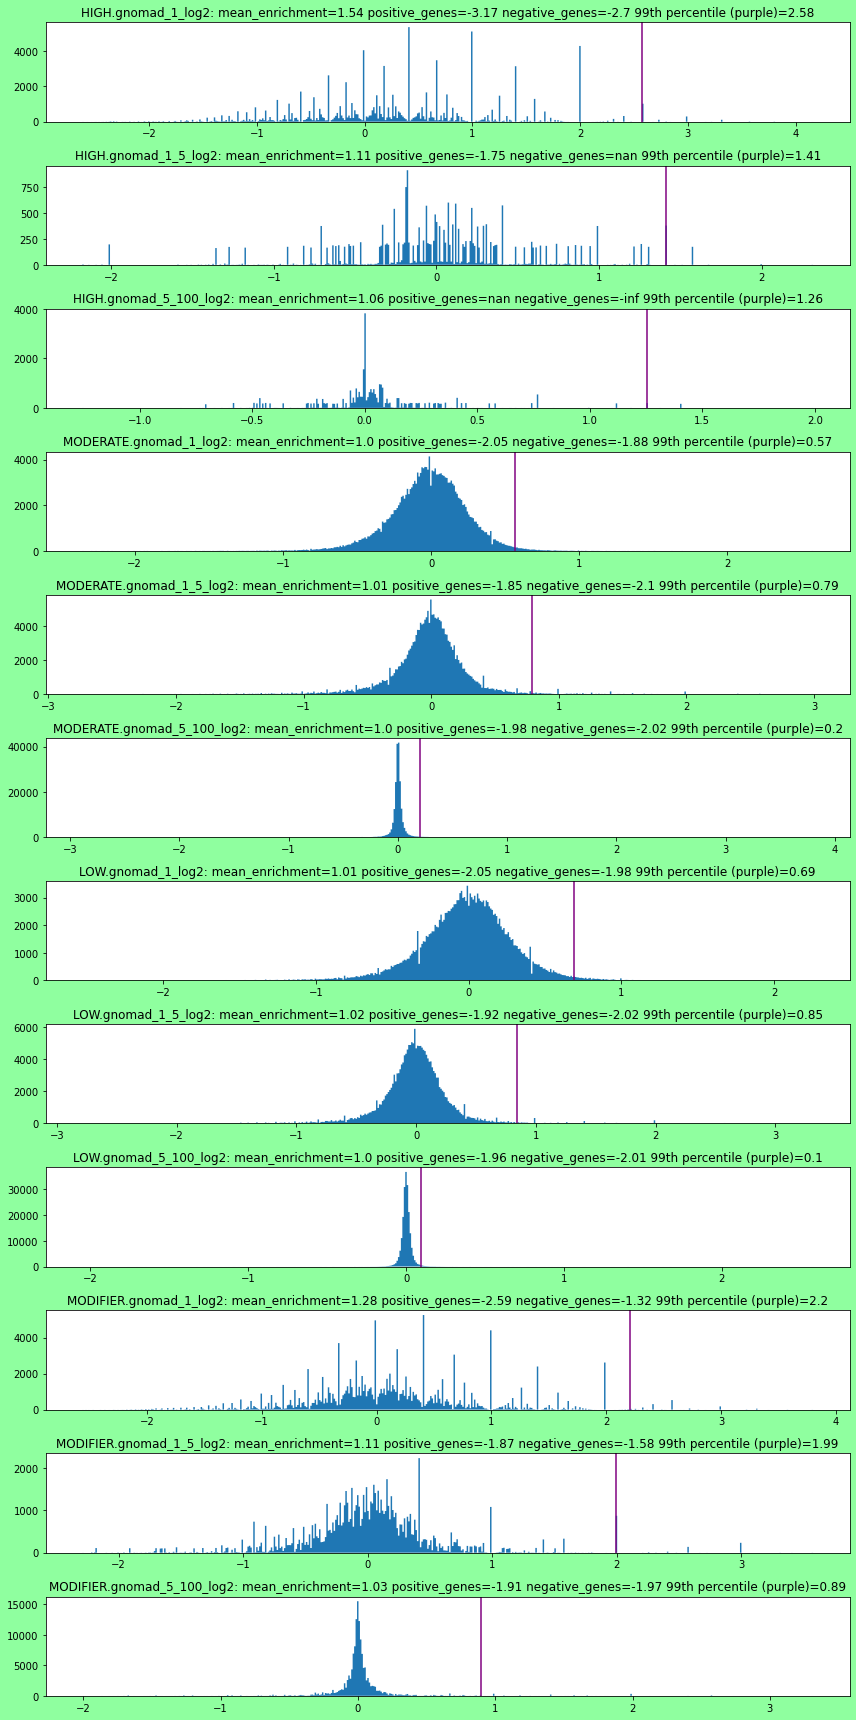

Done 200000 iterations


In [86]:
fraction_results_2 = pd.read_pickle("{0}_{1}_{2}_forgraph.pkl".format(case_count, control_count, iterations))
outliers = pd.DataFrame(columns=fraction_results_2.columns.values)

fig, axs = plt.subplots(
    len(fraction_results_2.columns),
    1,
    sharex="none",
    tight_layout=False,
    figsize=(12, 24),
    facecolor='xkcd:mint green',
)
i = 0
for frequency_column in fraction_results_2.columns:
    fraction_results_2[frequency_column].dropna(inplace=True)

    if fraction_results_2[frequency_column].any():
        # Average sample normalization enrichment ratios for "likely impactful" and "likely non-impactful" genes
        q_avg = np.divide(
            np.sum(df_case[df_case.gene.isin(rv_genes)][frequency_column]),
            np.sum(df_control[df_control.gene.isin(rv_genes)][frequency_column]),)
        q_avg_control_group = np.divide(
            np.sum(df_case[df_case.gene.isin(neg_control_genes)][frequency_column]),
            np.sum(
                df_control[df_control.gene.isin(neg_control_genes)][frequency_column]),)
        print(
            "Impact group (av-norm. ): {0}, case_genes_enrichment: {1}, control_genes_enrichment: {2}".format(
                frequency_column, q_avg, q_avg_control_group
            )
        )
        fraction_results_2[frequency_column + "log2"] = np.log2(
            fraction_results_2[frequency_column]).dropna()


        # Unused block
        mu, std = sp.norm.fit(fraction_results_2[frequency_column].dropna())
        percentile_99 = np.percentile(fraction_results_2[frequency_column + "log2"].dropna(), 99)
        xmin, xmax = (
            fraction_results_2[frequency_column].min(),
            fraction_results_2[frequency_column].dropna().max(),
        )
        x = np.linspace(mu - 3 * std, mu + 3*std, 100)
        _, bins, _ = axs[i].hist(
            fraction_results_2[frequency_column + "log2"],
            density=False,
            log=False,
            histtype="stepfilled",
            stacked=True,
            bins=500,
        )
        p = sp.norm.pdf(bins, mu, std)
        axs[i].set_title(
            "{0}: mean_enrichment={1} positive_genes={2} negative_genes={3} 99th percentile (purple)={4}".format(
                fraction_results_2[frequency_column].name  + "_log2",
                np.round(fraction_results_2[frequency_column].mean(), 2),
                np.round(np.log2(q_avg), 2),
                np.round(np.log2(q_avg_control_group), 2),
                np.round(percentile_99, 2)
                )
        )
        axs[i].axvline(percentile_99, color="purple")
        outliers[frequency_column] = fraction_results_2.loc[fraction_results_2[frequency_column] > percentile_99,frequency_column]
        i +=1
plt.show()
print("Done {0} iterations".format(iterations))


In [87]:
outliers

,HIGH.gnomad_1,HIGH.gnomad_1_5,HIGH.gnomad_5_100,MODERATE.gnomad_1,MODERATE.gnomad_1_5,MODERATE.gnomad_5_100,LOW.gnomad_1,LOW.gnomad_1_5,LOW.gnomad_5_100,MODIFIER.gnomad_1,MODIFIER.gnomad_1_5,MODIFIER.gnomad_5_100
3,5.969866,NaN,NaN,1.128631,NaN,0.999399,0.961812,0.947305,0.977522,NaN,NaN,NaN
27,3.183929,NaN,NaN,NaN,0.884425,1.002377,0.965998,NaN,1.022859,NaN,NaN,0.973564
30,2.984933,NaN,NaN,1.010285,0.999361,1.015355,0.941195,0.925762,1.015300,NaN,NaN,0.952457
61,3.316592,NaN,NaN,1.263464,1.094475,0.994228,1.224588,1.118537,1.003935,NaN,NaN,1.015851
72,2.653274,NaN,NaN,1.331922,1.000415,0.977522,0.884425,0.966550,1.027235,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
199919,3.979911,NaN,1.349122,1.211928,1.102021,1.004705,0.773348,1.020490,0.987533,NaN,NaN,0.930203
199936,3.979911,NaN,NaN,0.858736,0.967339,0.896717,0.706713,1.392969,0.986287,3.183929,NaN,1.015075
199974,2.984933,NaN,NaN,0.949337,0.962355,0.986165,0.869560,1.027676,0.936450,NaN,NaN,1.064908
199975,3.979911,NaN,NaN,0.902113,0.975468,1.000108,1.124757,0.855187,0.999546,NaN,NaN,0.958793
